# Notes - Features 3

In [2]:
import duckdb
import os
import numpy as np
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
from variables import Variables as vars

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = 1673025012
np.random.seed(RANDOM_SEED)

In [3]:
con = duckdb.connect("./data/us_births.db", read_only=True)

In [4]:
df = con.execute("""
    SELECT
        year,
        me_pres,
        count(*)
    FROM us_births
    GROUP BY year, me_pres
    ORDER BY year, me_pres
    """).df()
df

,year,me_pres,count_star()
0,0,1.7765824089018436e-307,41
1,0,1.7800590868057611e-307,1
2,0,1.787012442613596e-307,12
3,0,None,5
4,1989,None,4045693
...,...,...,...
106,2023,9.0,7171
107,2024,1.0,3438227
108,2024,2.0,158789
109,2024,3.0,30960


In [5]:
df = con.execute(
    """
    SELECT
        year,
        -- (training label) indicated if C or P, otherwise not
        CASE
            WHEN COALESCE (ca_down, ca_downs) = 'C' THEN 1::UTINYINT
            WHEN COALESCE (ca_down, ca_downs) = 'P' THEN 1::UTINYINT
            ELSE 0::UTINYINT
        END AS ca_down_c_or_p,
        -- maternal age in years
        mage_c,
        -- father's combined age in years
        CASE
            WHEN fagecomb >= 9 AND fagecomb < 99 THEN fagecomb
            ELSE NULL
        END AS fagecomb,
        -- father's age recode
        CASE
            WHEN fagerec11 >= 1 AND fagerec11 < 10 THEN fagerec11
            ELSE NULL
        END AS fagerec11,
        -- pre-pregnancy weight recode (in pounds)
        CASE
            WHEN pwgt_r >= 75 AND pwgt_r <= 375 THEN pwgt_r
            ELSE NULL
        END AS pwgt_r,
        -- delivery weight recode (in pounds)
        CASE
            WHEN dwgt_r >= 100 AND dwgt_r <= 400 THEN dwgt_r
            ELSE NULL
        END AS dwgt_r,
        -- weight gain in pounds (98 = 98+)
        CASE
            WHEN wtgain >= 0 AND wtgain <= 98 THEN wtgain
            ELSE NULL
        END AS wtgain,
        -- weight gain recode
        CASE
            WHEN wtgain_rec >= 1 AND wtgain_rec <= 5 THEN wtgain_rec
            ELSE NULL
        END AS wtgain_rec,
        -- previous preterm birth
        CASE
            WHEN rf_ppterm = 'Y' THEN 1::UTINYINT
            WHEN rf_ppterm = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_ppterm,
        -- fertility enhancing drugs
        CASE
            WHEN rf_fedrg = 'Y' THEN 1::UTINYINT
            WHEN rf_fedrg = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_fedrg,
        -- asst. reproductive technology
        CASE
            WHEN rf_artec = 'Y' THEN 1::UTINYINT
            WHEN rf_artec = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_artec,
        -- no risk factors reported
        CASE
            WHEN no_risks <= 1 THEN no_risks
            ELSE NULL
        END AS no_risks,
        -- induction of labor
        CASE
            WHEN ld_indl = 'Y' THEN 1::UTINYINT
            WHEN ld_indl = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ld_indl,
        -- fetal presentation at delivery (TODO: remove cast when import fixed)
        CASE
            WHEN CAST(me_pres as UTINYINT) >= 1 AND CAST(me_pres as UTINYINT)  <= 3 THEN CAST(me_pres as UTINYINT)
            ELSE NULL
        END AS me_pres,
        -- final route and method of delivery (TODO: remove cast when import fixed)
        CASE
            WHEN CAST(me_route as UTINYINT) >= 1 AND CAST(me_route as UTINYINT)  <= 3 THEN CAST(me_route as UTINYINT)
            ELSE NULL
        END AS me_route,
        -- delivery method recode
        CASE
            WHEN dmeth_rec >= 1 AND dmeth_rec <= 2 THEN dmeth_rec
            ELSE NULL
        END AS dmeth_rec,
        -- attendant at birth
        CASE
            WHEN attendant >= 1 AND attendant <= 5 THEN attendant
            ELSE NULL
        END AS attendant,
        -- sex of baby
        CASE
            WHEN sex = 'M' THEN 1::UTINYINT
            WHEN sex = 'F' THEN 0::UTINYINT
            ELSE NULL
        END AS sex,
        -- congenital disorder
        CASE
            WHEN ca_disor = 'C' THEN 1::UTINYINT
            WHEN ca_disor = 'P' THEN 2::UTINYINT
            WHEN ca_disor = 'N' THEN 0::UTINYINT
            ELSE NULL
        END
        AS ca_disor,
        -- congenital heart defect
        CASE
            WHEN ca_cchd = 'Y' THEN 1::UTINYINT
            WHEN ca_cchd = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_cchd,
        -- ca_cdh
        CASE
            WHEN ca_cdh = 'Y' THEN 1::UTINYINT
            WHEN ca_cdh = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_cdh,
        -- omphalocele
        CASE
            WHEN ca_omph = 'Y' THEN 1::UTINYINT
            WHEN ca_omph = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_omph,
        -- gastroschisis
        CASE
            WHEN ca_gast = 'Y' THEN 1::UTINYINT
            WHEN ca_gast = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_gast,
        -- maternal body mass index
        CASE
            WHEN bmi >= 13.0 AND bmi < 69.9 THEN bmi
            ELSE NULL
        END
        AS bmi,
        -- maternal bmi recode
        CASE
            WHEN bmi_r >= 1 AND bmi_r <= 6 THEN bmi_r
            ELSE NULL
        END
        AS bmi_r,
        -- maternal education
        CASE
            WHEN  meduc < 9 THEN meduc
            ELSE NULL
        END AS meduc,
        -- paternal education
        CASE
            WHEN  feduc < 9 THEN feduc
            ELSE NULL
        END AS feduc,
        -- maternal race
        CASE
            WHEN  mrace6 < 7 THEN mrace6
            ELSE NULL
        END AS mrace6,
        -- paternal race
        CASE
            WHEN  frace6 < 7 THEN frace6
            ELSE NULL
        END AS frace6,
        -- maternal hispanic origin
        CASE
            WHEN  mhisp_r < 6 THEN mhisp_r
            ELSE NULL
        END AS mhisp_r,
        -- paternal hispanic origin
        CASE
            WHEN  fhisp_r < 6 THEN fhisp_r
            ELSE NULL
        END AS fhisp_r,
        -- payment source recode
        CASE
            WHEN  pay_rec < 5 THEN pay_rec
            ELSE NULL
        END AS pay_rec,
        -- supplemental nutrition program for women, infants, and children
        CASE
            WHEN wic = 'Y' THEN 1::UTINYINT
            WHEN wic = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS wic
    FROM
        us_births
    WHERE year >= 2015
    ORDER BY
        year, dob_mm
    """
).df()
df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,year,ca_down_c_or_p,mage_c,fagecomb,fagerec11,pwgt_r,dwgt_r,wtgain,wtgain_rec,rf_ppterm,...,bmi,bmi_r,meduc,feduc,mrace6,frace6,mhisp_r,fhisp_r,pay_rec,wic
0,2015,0,27,28,4,115,142,27,3,0,...,20.400000,2,4,3,<NA>,1,0,0,3,0
1,2015,0,29,33,5,160,190,30,3,0,...,25.799999,3,7,3,<NA>,<NA>,5,4,2,0
2,2015,0,25,23,3,120,139,19,2,0,...,19.400000,2,3,3,<NA>,1,0,0,1,1
3,2015,0,29,37,6,120,150,30,3,1,...,21.900000,2,3,3,<NA>,1,0,0,1,1
4,2015,0,21,<NA>,<NA>,278,285,7,1,0,...,52.500000,6,4,<NA>,<NA>,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37577956,2024,0,37,<NA>,<NA>,130,169,39,4,0,...,20.400000,2,2,<NA>,1,<NA>,0,<NA>,1,0
37577957,2024,0,27,28,4,180,215,35,4,1,...,28.200001,3,4,5,1,1,0,5,1,1
37577958,2024,0,34,<NA>,<NA>,140,138,0,1,0,...,26.400000,3,2,<NA>,1,<NA>,0,<NA>,1,1
37577959,2024,0,27,26,4,200,282,82,5,0,...,29.500000,3,6,3,1,1,0,0,3,0


In [6]:
df.dtypes

year               uint16
ca_down_c_or_p      uint8
mage_c              uint8
fagecomb            UInt8
fagerec11           UInt8
pwgt_r             UInt16
dwgt_r             UInt16
wtgain              UInt8
wtgain_rec          UInt8
rf_ppterm           UInt8
rf_fedrg            UInt8
rf_artec            UInt8
no_risks            UInt8
ld_indl             UInt8
me_pres             UInt8
me_route            UInt8
dmeth_rec           UInt8
attendant           UInt8
sex                 uint8
ca_disor            UInt8
ca_cchd             UInt8
ca_cdh              UInt8
ca_omph             UInt8
ca_gast             UInt8
bmi               float32
bmi_r              UInt16
meduc               UInt8
feduc               UInt8
mrace6              UInt8
frace6              UInt8
mhisp_r             UInt8
fhisp_r             UInt8
pay_rec             UInt8
wic                 UInt8
dtype: object

#### Missing values

In [7]:
df.isna().mean().sort_values(ascending=False)

attendant         1.000000
me_route          1.000000
rf_artec          0.980308
rf_fedrg          0.980308
mrace6            0.314269
frace6            0.184361
feduc             0.139118
fhisp_r           0.127617
fagerec11         0.117940
fagecomb          0.115820
wtgain_rec        0.031254
wtgain            0.031254
bmi               0.025708
bmi_r             0.025708
pwgt_r            0.022692
meduc             0.016733
dwgt_r            0.015909
wic               0.014127
mhisp_r           0.009235
pay_rec           0.009005
me_pres           0.006397
ca_disor          0.003632
ca_gast           0.003632
ca_cdh            0.003632
ca_cchd           0.003632
ca_omph           0.003632
rf_ppterm         0.003096
ld_indl           0.002537
no_risks          0.001342
dmeth_rec         0.000725
ca_down_c_or_p    0.000000
year              0.000000
mage_c            0.000000
sex               0.000000
dtype: float64

In [8]:
df.columns

Index(['year', 'ca_down_c_or_p', 'mage_c', 'fagecomb', 'fagerec11', 'pwgt_r',
       'dwgt_r', 'wtgain', 'wtgain_rec', 'rf_ppterm', 'rf_fedrg', 'rf_artec',
       'no_risks', 'ld_indl', 'me_pres', 'me_route', 'dmeth_rec', 'attendant',
       'sex', 'ca_disor', 'ca_cchd', 'ca_cdh', 'ca_omph', 'ca_gast', 'bmi',
       'bmi_r', 'meduc', 'feduc', 'mrace6', 'frace6', 'mhisp_r', 'fhisp_r',
       'pay_rec', 'wic'],
      dtype='object')

In [9]:
features = [
    "year", "mage_c", "fagecomb", "pwgt_r",
    "dwgt_r", "wtgain", "rf_ppterm", "rf_fedrg", "rf_artec",
    "no_risks", "ld_indl", "me_pres", "dmeth_rec",
    "sex", "ca_disor", "ca_cchd", "ca_cdh", "ca_omph",
    "ca_gast", "bmi", "meduc", "feduc", "mrace6", "frace6",
    "mhisp_r", "fhisp_r", "pay_rec", "wic"
]

X = df[features]
y = df["ca_down_c_or_p"]

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.1,
    random_state=RANDOM_SEED,
    stratify=y
)

In [12]:
from lightgbm import early_stopping, log_evaluation

categorical = [
    "rf_ppterm", "rf_fedrg", "rf_artec",
    "no_risks", "ld_indl", "me_pres", "dmeth_rec",
    "sex", "ca_disor", "ca_cchd", "ca_cdh", "ca_omph",
    "ca_gast", "meduc", "feduc", "mrace6", "frace6",
    "mhisp_r", "fhisp_r", "pay_rec", "wic"
]

numeric = [
    "year", "mage_c", "fagecomb", "pwgt_r", "dwgt_r", "wtgain", "bmi"
]

train_data = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=categorical,
    free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False
)

neg_count = (y_train == 0).count()
pos_count = (y_train == 1).count()
scale_pos_weight = np.sqrt(neg_count / pos_count)

params = {
    # Core
    "objective": "binary",
    "boosting_type": "gbdt",
    "data_sample_strategy": "goss",
    "top_rate": 0.1,
    "other_rate": 0.05,
    "learning_rate": 0.05,

    # tree complexity
    "num_leaves": 4096,
    "max_depth": 12,
    "min_data_in_leaf": 1000,
    "max_bin": 255,

    # subsampling for variance reduction
    "feature_fraction": 0.7,

    # Weight regularisation
    "lambda_l1": 0.0,
    "lambda_l2": 5.0,

    # Splitting threshold
    "min_gain_to_split": 0.0,

    # Imbalance handling
    "scale_pos_weight": scale_pos_weight,

    # categorical one-hot encoding
    "force_col_wise": True,
    "max_cat_threshold": 64,
    "max_cat_to_onehot": 32,

    # Metrics and infrastructure
    "metric": ["average_precision", "auc"],
    "num_threads": 22, #14,
    "verbose": 1,
}


gbm = lgb.train(
    params,
    train_data,
    num_boost_round=2000,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=5)
    ]
)


[LightGBM] [Info] Number of positive: 17861, number of negative: 33802303
[LightGBM] [Info] Total Bins 1058
[LightGBM] [Info] Number of data points in the train set: 33820164, number of used features: 28
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000528 -> initscore=-7.545665
[LightGBM] [Info] Start training from score -7.545665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	train's average_precision: 0.0186205	train's auc: 0.786587	valid's average_precision: 0.0193276	valid's auc: 0.770611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [13]:
from datetime import datetime
gbm.save_model(f"./output/features_model_{datetime.now().strftime("%Y%m%d%H%M")}.txt", num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import roc_auc_score, average_precision_score

y_valid_pred_proba = gbm.predict(X_valid, num_iteration=gbm.best_iteration)

auc = roc_auc_score(y_valid, y_valid_pred_proba)
aupr = average_precision_score(y_valid, y_valid_pred_proba)

print(f"Validation AUC:  {auc:.4f}")
print(f"Validation AUPRC:{aupr:.4f}")


Validation AUC:  0.7795
Validation AUPRC:0.0221


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr_age = LogisticRegression(max_iter=1000)
lr_age.fit(X_train[["mage_c"]], y_train)
p_age = lr_age.predict_proba(X_valid[["mage_c"]])[:, 1]
print("AUC (age only):", roc_auc_score(y_valid, p_age))


AUC (age only): 0.7110621942510322


In [16]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame({
    "feature": features,
    "importance_gain": importance_gain
}).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(f"./output/importance_gain_{datetime.now().strftime("%Y%m%d%H%M")}.csv", index=False)

df_imp_gain

,feature,importance_gain
1,mage_c,146897.670010
14,ca_disor,85308.173647
15,ca_cchd,79505.629467
5,wtgain,18554.351203
2,fagecomb,13508.346036
4,dwgt_r,11987.274988
19,bmi,11858.852829
11,me_pres,9367.996985
3,pwgt_r,8839.458884
20,meduc,7831.485573


In [17]:
pos_idx = y_valid[y_valid == 1].index
neg_idx = y_valid[y_valid == 0].index

n_pos_eval = min(10_000, len(pos_idx))
n_neg_eval = min(10 * n_pos_eval, len(neg_idx))  # 10:1 negatives:positives

rng = np.random.default_rng(123)

pos_sample = rng.choice(pos_idx, size=n_pos_eval, replace=False)
neg_sample = rng.choice(neg_idx, size=n_neg_eval, replace=False)

eval_idx = np.concatenate([pos_sample, neg_sample])
eval_idx = rng.permutation(eval_idx)  # shuffle

X_eval = X_valid.loc[eval_idx]
y_eval = y_valid.loc[eval_idx]


In [18]:
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.inspection import permutation_importance

def ap_scorer(estimator, X, y):
    proba = estimator.predict_proba(X)[:, 1]
    return average_precision_score(y, proba)

class LGBMWrapper:
    def __init__(self, booster):
        self.booster = booster

    def fit(self, X, y=None):
        # Required by sklearn API; we don't actually train here.
        return self

    def predict_proba(self, X):
        # LightGBM Booster.predict gives P(y=1) for binary by default
        p1 = self.booster.predict(X)
        p0 = 1.0 - p1
        return np.column_stack([p0, p1])

    def predict(self, X):
        p1 = self.booster.predict(X)
        return (p1 >= 0.5).astype(int)

model_wrapped = LGBMWrapper(gbm)


In [19]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ap_scorer,
    n_repeats=5,       # small but OK given size
    n_jobs=4,          # adjust for your machine
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame({
    "feature": X_eval.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std,
}).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(f"./output/permutation_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv", index=False)
perm_importance

,feature,importance_mean,importance_std
1,mage_c,0.181960,0.003462
14,ca_disor,0.113245,0.001308
15,ca_cchd,0.083141,0.002269
5,wtgain,0.015339,0.001734
11,me_pres,0.010251,0.001526
23,frace6,0.004119,0.000790
20,meduc,0.003997,0.000743
12,dmeth_rec,0.002905,0.000673
22,mrace6,0.002401,0.001026
0,year,0.002193,0.000868


In [20]:
# e.g. take all positives from X_eval and match them 1:2 with negatives
pos_eval_idx = y_eval[y_eval == 1].index
neg_eval_idx = y_eval[y_eval == 0].index

n_pos_shap = min(5_000, len(pos_eval_idx))
n_neg_shap = min(2 * n_pos_shap, len(neg_eval_idx))  # 2:1 neg:pos

pos_shap = rng.choice(pos_eval_idx, size=n_pos_shap, replace=False)
neg_shap = rng.choice(neg_eval_idx, size=n_neg_shap, replace=False)

shap_idx = np.concatenate([pos_shap, neg_shap])
shap_idx = rng.permutation(shap_idx)

X_shap = X_eval.loc[shap_idx]
y_shap = y_eval.loc[shap_idx]


In [21]:
import shap

# Tell SHAP this is a LightGBM model
explainer = shap.TreeExplainer(gbm)
explanation = explainer(X_shap)
shap_values = explanation.values

# Handle both cases: list or array
if isinstance(shap_values, list):
    shap_pos = shap_values[1]  # SHAP values for positive class
else:
    shap_pos = shap_values     # already positive class

# Global importance: mean |SHAP|
shap_importance = pd.DataFrame({
    "feature": X_shap.columns,
    "mean_abs_shap": np.mean(np.abs(shap_pos), axis=0),
}).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(f"./output/shap_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv", index=False)

shap_importance


,feature,mean_abs_shap
1,mage_c,0.598517
5,wtgain,0.140895
14,ca_disor,0.102961
15,ca_cchd,0.084758
11,me_pres,0.075141
23,frace6,0.056066
12,dmeth_rec,0.056058
2,fagecomb,0.043395
20,meduc,0.040152
22,mrace6,0.037692


RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

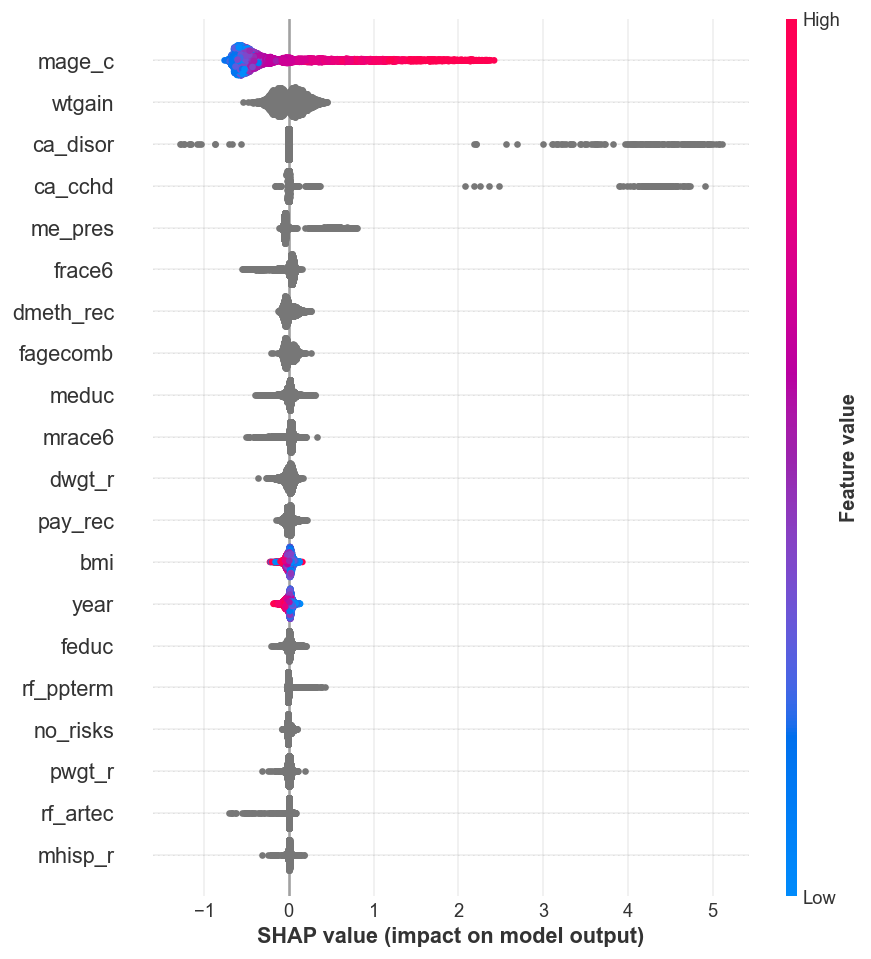

In [22]:
rng = np.random.default_rng(RANDOM_SEED)
shap.summary_plot(shap_values, X_shap, rng=rng)

In [ ]:
X_shap_fp = X_shap.astype("float32")
for name in X_shap_fp.columns:
    print(f"\nFeature: {name}")
    shap.dependence_plot(name, shap_values, X_shap_fp)

In [ ]:
#con.close()